In [262]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
import mean_wrapper as mw
from GmGM import Dataset, GmGM
from mean_wrapper import kron_sum, vec_kron_sum
import mean_wrapper as mw
import random
import BiGLasso_Methods as bg

SEED = 0

# Make palette colorblind friendly
plt.style.use('tableau-colorblind10')
hatches = ['|', '//', 'oo', 'x', '+', '-', 'OO', '.', '*', '\\']
lines = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5))]

# Prevent type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

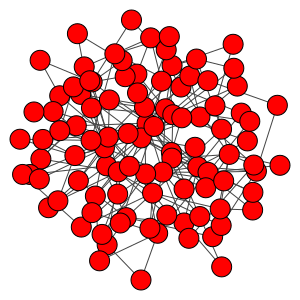

In [263]:
random.seed(SEED)
graph = ig.Graph.Barabasi(100, 2)

# Display graph
ig.plot(graph, bbox=(0, 0, 300, 300))

In [264]:
random.seed(SEED)
num_nodes = 5
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
adj_mat = np.array(graph.get_adjacency().data)

# Add diagonal so that it forms a PSD matrix!
adj_mat = adj_mat / 1.1 + np.eye(num_nodes)

display(adj_mat)
display(kron_sum([adj_mat, adj_mat]).toarray())

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.90909091, 0.        , 0.        ],
       [0.        , 0.90909091, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.90909091],
       [0.        , 0.        , 0.        , 0.90909091, 1.        ]])

array([[2.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 2.        , 0.90909091, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.90909091, 2.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [265]:
def fast_kronecker_normal(
    Psis: list[np.ndarray],
    size: int,
    fail_if_not_posdef: bool = False,
    mean: np.array = None,
) -> np.ndarray:
    """
    Inputs:
        Psis: List of (d_i, d_i) precision matrices, of length K >= 2
        size: Number of samples
        fail_if_not_posdef:
            If True, raise Exception if any of the Psis is not positive definite
        mean: Mean of the distribution

    Outputs:
        Xs: Sample of Kronecker sum structured normal distribution
    """


    K = len(Psis)
    ds = [Psi.shape[0] for Psi in Psis]
    vs, Vs = zip(*[np.linalg.eigh(Psi) for Psi in Psis])
    diag_precisions = vec_kron_sum(vs)
    
    # Check if positive definite
    min_diag = diag_precisions.min()
    if min_diag < 0:
        if fail_if_not_posdef:
            raise Exception("KS of Psis not Positive Definite")
        diag_precisions -= (min_diag-1)
    
    # Sample from diagonalized, vectorized distribution
    z = stats.multivariate_normal(cov=1).rvs(
        size=size*np.prod(ds)
    ).reshape(size, np.prod(ds)) / np.sqrt(diag_precisions)
    
    # Reshape into a tensor
    Xs: np.ndarray = z.reshape(size, *ds)
    
    # Undiagonalize the distribution
    for k in range(K):
        Xs = np.moveaxis(
            np.moveaxis(Xs, k+1, -1) @ Vs[k].T,
            -1,
            k+1
        )

    if mean is not None:
        Xs += mean.reshape(1, *ds)

    return Xs

In [266]:
def pr_curve(
    ground_truth: np.ndarray,
    output: np.ndarray,
    num_points: int = 1000
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(num_points)
    recalls = np.zeros(num_points)
    thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over thresholds
    for i, threshold in enumerate(thresholds):
        # Threshold output
        output_thresholded = (output > threshold).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

def pr_curve_alg(
    ground_truth: np.ndarray,
    alg: callable,
    reg_params: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(reg_params.shape[0])
    recalls = np.zeros(reg_params.shape[0])
    #thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over reg_params
    for i, param in enumerate(reg_params):
        # Threshold output
        print(f"TeraLasso lambda: {param}")
        output = alg(param)
        output_thresholded = (output != 0).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

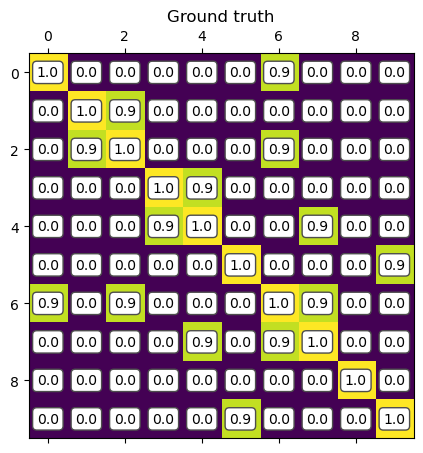

In [267]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")

for (i, j), z in np.ndenumerate(ground_truth):
    ax1.text(
        j,
        i,
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )

# Run Experiments

In [268]:
def precision_test(
    num_nodes: int,
    graph: ig.Graph,
    offset_func: callable,
    title: str
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(SEED)
    np.random.seed(SEED)

    # Create a random graph
    ground_truth = np.array(graph.get_adjacency().data)

    # Add diagonal so that it forms a PSD matrix!
    ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

    fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))


    algorithms = (
        [
            "GmGM",
            "GmGM + mean estimation",
            #"GmGM + nonparanormal",
            "TeraLasso",
            "TeraLasso + mean estimation"
        ]
    )
    for idx, algorithm in enumerate(algorithms):
        print(f"Running {algorithm}")
        ps = []
        rs = []


        # Create a fake output
        num_trials = 10
        for i in range(num_trials):
            print(f"\tTrial {i} of {num_trials}")

            # Generate data
            dfs = num_nodes
            data_dependencies = stats.wishart(df=dfs, scale=np.eye(num_nodes)).rvs()
            data_dependencies /= dfs
            output = fast_kronecker_normal(
                [data_dependencies, ground_truth],
                1
            )
            output = offset_func(output)

            dataset = Dataset(
                dataset={"data": output},
                structure={"data": ("", "rows", "columns")}
            )
            result = None
            run_alg = None
            if algorithm == "GmGM":
                result = GmGM(
                    dataset,
                    to_keep=0.5,
                    threshold_method="statistical-significance",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
            elif algorithm == "GmGM + nonparanormal":
                result = GmGM(
                    dataset,
                    to_keep=0.5,
                    threshold_method="statistical-significance",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=True,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
            elif algorithm == "GmGM + mean estimation":
                def gmgm_estimator(data):
                    output = GmGM(
                        data,
                        to_keep=0.5,
                        threshold_method="statistical-significance",
                        min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                        n_comps=None,
                        verbose=False,
                        centering_method=None,
                        use_nonparanormal_skeptic=False,
                        nonparanormal_evec_backend="COCA",
                        readonly=False,
                        calculate_explained_variance=True,
                        batch_size=1000
                    )
                    return output.precision_matrices
                NKS = mw.NoncentralKS(
                    gmgm_estimator,
                    ({axis: np.zeros(num_nodes) for axis in dataset.all_axes - dataset.batch_axes}, 0),
                    {axis: np.eye(num_nodes) for axis in dataset.all_axes - dataset.batch_axes},
                )
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats

                means, precisions = NKS.fit(dataset, verbose=True, tol=1e-3, max_iter=10)
                result = result_container(precisions)
            elif algorithm == "TeraLasso":
                def alg(reg_param):
                    return bg.TeraLasso(
                        dataset,
                        reg_param,
                        use_nonparanormal_skeptic=False
                    ).precision_matrices["columns"].toarray()
                run_alg = alg
            elif algorithm == "TeraLasso + mean estimation":
                def alg(reg_param):
                    def tera_internal(data):
                        return bg.TeraLasso(
                            data,
                            reg_param,
                            use_nonparanormal_skeptic=False
                        ).precision_matrices
                    NKS = mw.NoncentralKS(
                        tera_internal,
                        ({axis: np.zeros(num_nodes) for axis in dataset.all_axes - dataset.batch_axes}, 0),
                        {axis: np.eye(num_nodes) for axis in dataset.all_axes - dataset.batch_axes},
                    )

                    _, precisions = NKS.fit(dataset, verbose=True, tol=1e-3, max_iter=10)
                    return precisions["columns"].toarray()
                run_alg = alg
            else:
                raise Exception(f"Unknown algorithm: {algorithm}")

            if run_alg is None:
                ys, xs = pr_curve(ground_truth, result.precision_matrices["columns"].toarray())
            else:
                # Manually chosen bounds to cover span from ~perfect recall to ~perfect precision
                if algorithm == "TeraLasso":
                    reg_params = 10**np.linspace(-1, 0, 25)
                elif algorithm == "TeraLasso + mean estimation":
                    reg_params = 10**np.linspace(-2, -1, 10)
                ys, xs = pr_curve_alg(ground_truth, run_alg, reg_params)
                #print(ys, xs)
            
            ps.append(ys)
            rs.append(xs)
            #ax.plot(xs, ys)


        num_points = 100
        xs = np.linspace(0, 1, num_points)

        if algorithm == "GmGM":
            label = "GmGM"
        elif algorithm == "GmGM + mean estimation":
            label = "Noncentral GmGM"
        elif algorithm == "TeraLasso":
            label = "TeraLasso"
        elif algorithm == "TeraLasso + mean estimation":
            label = "Noncentral TeraLasso"
        elif algorithm == "GmGM + nonparanormal":
            label = "Nonparanormal GmGM"

        lineplot = ax1.plot(-1, -1)#, label=label)
        xs = np.linspace(0.01, 1, 100)
        min_ys = np.zeros(100) + 1
        max_ys = np.zeros(100)
        for p, r in zip(ps, rs):
            f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
            min_ys = np.minimum(min_ys, f(xs))
            max_ys = np.maximum(max_ys, f(xs))
            #plt.plot(xs, f(xs), color='black', alpha=0.1)

        ax1.plot(
            xs,
            min_ys,
            color=lineplot[0].get_color(),
            linestyle=lines[idx],
            alpha=0.3
        )
        ax1.plot(
            xs,
            max_ys,
            color=lineplot[0].get_color(),
            linestyle=lines[idx],
            alpha=0.3
        )
        ax1.plot(
            xs,
            (min_ys + max_ys) / 2,
            color=lineplot[0].get_color(),
            label=label,
            linestyle=lines[idx]
        )
        ax1.fill_between(
            xs,
            min_ys,
            max_ys,
            color=lineplot[0].get_color(),
            alpha=0.3
        )#, hatch=hatches[idx]+hatches[idx])

    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title(
        f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)'
        + f'\n [{title}]'
    )
    ax1.legend()

    return fig, ax1

## Precision Tests

### Total Offset

Running GmGM
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 28.170500268017257)
Iteration: 2 (Change: 40.60354264475542)
Iteration: 3 (Change: 0.8217289728627751)
Iteration: 4 (Change: 0.012131092235396452)
Converged in 5 iterations
Iteration: 5 (Change: 0.0002703595338506386)
	Trial 1 of 10
Iteration: 1 (Change: 17.499127633527017)
Iteration: 2 (Change: 45.67853847193351)
Iteration: 3 (Change: 0.6309203771706616)
Iteration: 4 (Change: 0.01127205787706257)
Converged in 5 iterations
Iteration: 5 (Change: 0.0002066002874586742)
	Trial 2 of 10
Iteration: 1 (Change: 24.725474865829007)
Iteration: 2 (Change: 42.1710578920248)
Iteration: 3 (Change: 1.1670711613227511)
Iteration: 4 (Change: 0.022286107496272436)
Converged in 5 iterations
Iteration: 5 (Change: 0.0005159700069924811)
	Trial 3 of 10
Iteration: 1 (Change: 34.75446989018772)
Iteration: 2 (Change: 38.81361

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


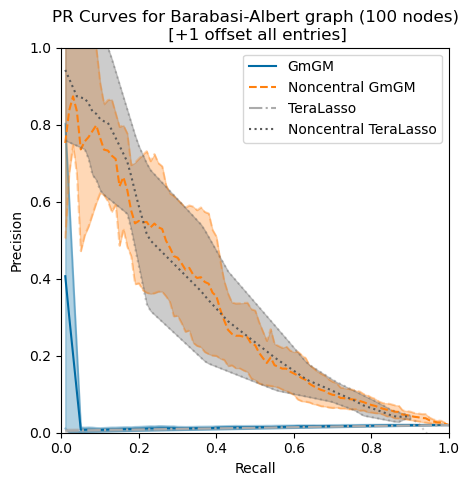

In [269]:
# Create a random graph
num_nodes = 100
graph = ig.Graph.Barabasi(n=num_nodes)#, p=0.01)

def total_offset(x):
    x = x + 1
    return x

fig, axs = precision_test(
    num_nodes,
    graph,
    total_offset,
    title="+1 offset all entries"
)
fig.savefig('./out-figs/synthetic/total-offset.pdf', bbox_inches="tight")

### Total and Axis-Wise Offsets

Running GmGM
	Trial 0 of 10
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 21.401426478494667)
Iteration: 2 (Change: 43.0092051523619)
Iteration: 3 (Change: 10.435589218240485)
Iteration: 4 (Change: 0.16534351329975047)
Iteration: 5 (Change: 0.002549067800690602)
Converged in 6 iterations
Iteration: 6 (Change: 6.903778395787154e-05)
	Trial 1 of 10
Iteration: 1 (Change: 22.687203531376884)
Iteration: 2 (Change: 22.713252880126717)
Iteration: 3 (Change: 26.515206220531812)
Iteration: 4 (Change: 0.7512308990223279)
Iteration: 5 (Change: 0.016955752349824424)
Converged in 6 iterations
Iteration: 6 (Change: 0.0004280359844953479)
	Trial 2 of 10
Iteration: 1 (Change: 26.58008094120832)
Iteration: 2 (Change: 14.163056376003231)
Iteration: 3 (Change: 37.71404415153857)
Iteration: 4 (Change: 0.5124077795068869)
Iteration: 5 (Change: 0.011208

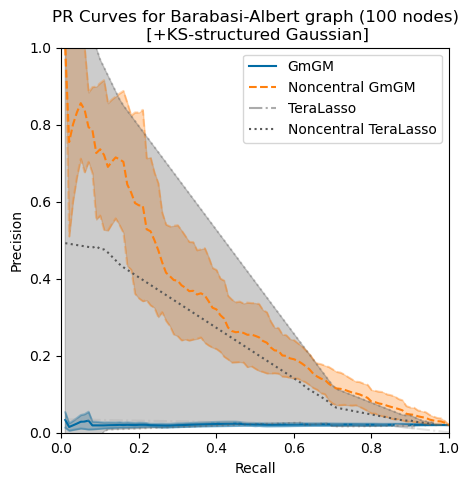

In [270]:
# Create a random graph
num_nodes = 100
graph = ig.Graph.Barabasi(n=num_nodes)#, p=0.01)

def total_offset(x):
    x = x + 1
    x = x + np.random.normal(0, 1, (x.shape[0], 1))
    x = x + np.random.normal(0, 1, (1, x.shape[1]))
    return x

fig, axs = precision_test(
    num_nodes,
    graph,
    total_offset,
    title="+KS-structured Gaussian"
)
fig.savefig('./out-figs/synthetic/ks-structured-offset.pdf', bbox_inches="tight")

# Axis-Wise Offset

Running GmGM
	Trial 0 of 10
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 23.53997293574337)
Iteration: 2 (Change: 42.79576183039556)
Iteration: 3 (Change: 12.987777684653944)
Iteration: 4 (Change: 0.20187804654011654)
Iteration: 5 (Change: 0.0030678110777193025)
Converged in 6 iterations
Iteration: 6 (Change: 7.987902389514743e-05)
	Trial 1 of 10
Iteration: 1 (Change: 23.511506446536057)
Iteration: 2 (Change: 43.832835235361806)
Iteration: 3 (Change: 1.9045922050793083)
Iteration: 4 (Change: 0.03574962245230496)
Iteration: 5 (Change: 0.0010825279186219357)
Converged in 6 iterations
Iteration: 6 (Change: 3.912274234688344e-05)
	Trial 2 of 10
Iteration: 1 (Change: 41.86506696146869)
Iteration: 2 (Change: 39.2439253724008)
Iteration: 3 (Change: 9.470900366797482)
Iteration: 4 (Change: 0.3907502713392295)
Iteration: 5 (Change: 0.00733

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_57177/2853546986.py:198: RuntimeWarning: invalid value encountered in add
  (min_ys + max_ys) / 2,


Running TeraLasso + mean estimation
	Trial 0 of 10
TeraLasso lambda: 0.01
Iteration: 1 (Change: 7.243924137796282)
Iteration: 2 (Change: 1.2790837371537735)
Iteration: 3 (Change: 22170.866416748187)
Iteration: 4 (Change: 22170.265344806106)
Iteration: 5 (Change: 2987.23681387754)
Iteration: 6 (Change: 2987.4571715896923)
Iteration: 7 (Change: 23.281668886423777)
Iteration: 8 (Change: 51835.78751920244)
Iteration: 9 (Change: 51837.63152538551)
Maximum number of iterations reached
Iteration: 10 (Change: 12.805179944056302)
TeraLasso lambda: 0.01291549665014884
Iteration: 1 (Change: 7.243953559786165)
Iteration: 2 (Change: 1.2791932893572409)
Iteration: 3 (Change: 22106.46850092552)
Iteration: 4 (Change: 22105.661351201405)
Iteration: 5 (Change: 29.089985066275005)
Iteration: 6 (Change: 1.2789021460620718)
Iteration: 7 (Change: 1732.4575875074945)
Iteration: 8 (Change: 1735.6631600032626)
Iteration: 9 (Change: 3.4310430406206573)
Maximum number of iterations reached
Iteration: 10 (Change:

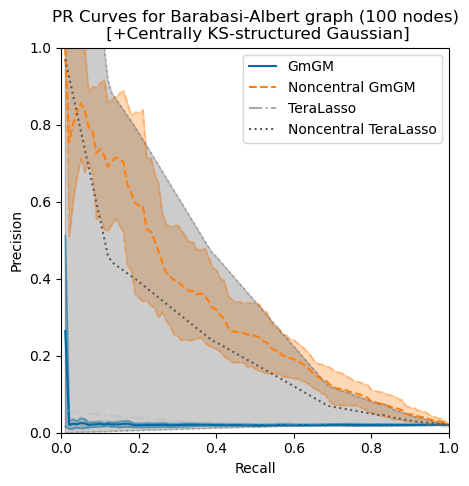

In [271]:
# Create a random graph
num_nodes = 100
graph = ig.Graph.Barabasi(n=num_nodes)#, p=0.01)

def total_offset(x):
    #x = x + 1
    x = x + np.random.normal(0, 1, (x.shape[0], 1))
    x = x + np.random.normal(0, 1, (1, x.shape[1]))
    return x

fig, axs = precision_test(
    num_nodes,
    graph,
    total_offset,
    title="+Centrally KS-structured Gaussian"
)
fig.savefig('./out-figs/synthetic/central-ks-structured-offset.pdf', bbox_inches="tight")

### Unstructured Poisson Noise

Running GmGM
	Trial 0 of 10
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 22.712009118625485)
Iteration: 2 (Change: 43.105092794068)
Iteration: 3 (Change: 1.004635742441706)
Iteration: 4 (Change: 0.11786587510484176)
Iteration: 5 (Change: 0.11604580582854081)
Iteration: 6 (Change: 0.11604259153319156)
Iteration: 7 (Change: 0.11604250458978711)
Iteration: 8 (Change: 0.11604249257800887)
Iteration: 9 (Change: 0.11604249261593945)
Maximum number of iterations reached
Iteration: 10 (Change: 0.1160424926066655)
	Trial 1 of 10
Iteration: 1 (Change: 32.955566549368086)
Iteration: 2 (Change: 39.67179649980526)
Iteration: 3 (Change: 0.6781804755456727)
Iteration: 4 (Change: 0.010780972079302797)
Converged in 5 iterations
Iteration: 5 (Change: 0.00027420646881994243)
	Trial 2 of 10
Iteration: 1 (Change: 23.7503339909999)
Iteration: 2 (Change

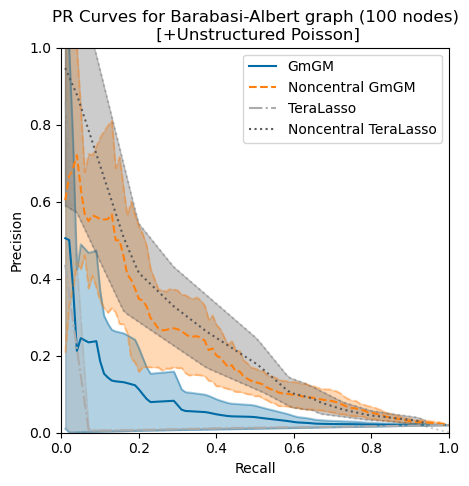

In [276]:
# Create a random graph
num_nodes = 100
graph = ig.Graph.Barabasi(n=num_nodes)#, p=0.01)

def total_offset(x):
    # i.e. variance = 0.05
    x = x + np.random.poisson(10, x.shape) / 14
    return x

fig, axs = precision_test(
    num_nodes,
    graph,
    total_offset,
    title="+Unstructured Poisson"
)
fig.savefig('./out-figs/synthetic/unstructured-poisson-offset.pdf', bbox_inches="tight")

### Unstructured Gaussian Noise

Running GmGM
	Trial 0 of 10
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 57.40845017127144)
Iteration: 2 (Change: 8.739867737800985)
Iteration: 3 (Change: 0.18964761306504407)
Iteration: 4 (Change: 0.0034477424448552015)
Converged in 5 iterations
Iteration: 5 (Change: 9.264665007846698e-05)
	Trial 1 of 10
Iteration: 1 (Change: 57.493366975231176)
Iteration: 2 (Change: 8.645731800897693)
Iteration: 3 (Change: 0.2099817957182343)
Iteration: 4 (Change: 0.003728954830297874)
Converged in 5 iterations
Iteration: 5 (Change: 9.640724623839414e-05)
	Trial 2 of 10
Iteration: 1 (Change: 58.28687480246995)
Iteration: 2 (Change: 8.551861159507895)
Iteration: 3 (Change: 0.17049602691216828)
Iteration: 4 (Change: 0.002974471978389753)
Converged in 5 iterations
Iteration: 5 (Change: 7.467813660665832e-05)
	Trial 3 of 10
Iteration: 1 (Change: 57.33896657428036)
Iteration: 2 (Change: 9.152

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_57177/2853546986.py:198: RuntimeWarning: invalid value encountered in add
  (min_ys + max_ys) / 2,


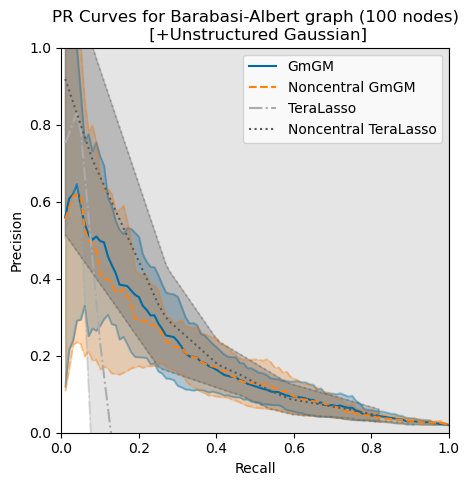

In [275]:
# Create a random graph
num_nodes = 100
graph = ig.Graph.Barabasi(n=num_nodes)#, p=0.01)

def total_offset(x):
    # i.e. variance = 0.05
    x = x + np.random.normal(0, np.sqrt(10), x.shape) / 14
    return x

fig, axs = precision_test(
    num_nodes,
    graph,
    total_offset,
    title="+Unstructured Gaussian"
)
fig.savefig('./out-figs/synthetic/unstructured-gaussian-offset.pdf', bbox_inches="tight")